In [2]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import preprocessors as pp

from constants import * 

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [3]:
CATEGORICAL_VARS

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageType',
 'PavedDrive',
 'PoolQC',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

In [4]:
# load data
df = pd.read_csv('data/train.csv')

In [10]:
# set up the pipeline
price_pipe = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),

    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),

    # add missing indicator
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    # impute numerical variables with the mean
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA
    )),
    
    
    # == TEMPORAL VARIABLES ====
    ('elapsed_time', pp.TemporalVariableTransformer(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    ('drop_features', DropFeatures(features_to_drop=[REF_VAR])),

   

    # ==== VARIABLE TRANSFORMATION =====
    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    
    ('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),
    
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)),
    

    # === mappers ===
    ('mapper_qual', pp.Mapper(
        variables=QUAL_VARS, mappings=QUAL_MAPPINGS)),

    ('mapper_exposure', pp.Mapper(
        variables=EXPOSURE_VARS, mappings=EXPOSURE_MAPPINGS)),

    ('mapper_finish', pp.Mapper(
        variables=FINISH_VARS, mappings=FINISH_MAPPINGS)),

    ('mapper_garage', pp.Mapper(
        variables=GARAGE_VARS, mappings=GARAGE_MAPPINGS)),
    
    ('mapper_fence', pp.Mapper(
        variables=FENCE_VARS, mappings=FENCE_MAPPINGS)),


    # == CATEGORICAL ENCODING
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS
    )),

    # encode categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),
    
      ('scaler', MinMaxScaler()),
    ('Lasso', Lasso(alpha=0.001, random_state=42)),
])

In [11]:
df['MSSubClass'] = df['MSSubClass'].astype('O')

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Id', 'SalePrice'], axis=1), # predictive variables
    df['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

y_train = np.log(y_train)
y_test = np.log(y_test)

In [12]:
price_pipe.fit(X_train, y_train)

C:\Users\gonz3\anaconda3\lib\site-packages\scipy\stats\morestats.py:1476: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
C:\Users\gonz3\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2522: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\gonz3\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2115: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\gonz3\anaconda3\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['Alley', 'FireplaceQu', 'PoolQC',
                                               'Fence', 'MiscFeature'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['MasVnrType', 'BsmtQual',
                                               'BsmtCond', 'BsmtExposure',
                                               'BsmtFinType1', 'BsmtFinType2',
                                               'Electrical', 'GarageType',
                                               'GarageFinish', 'GarageQual',
                                               'GarageCon...
                                           'LandSlope', 'Neighborhood',
                                           'Condition1', 'Condition2',
                                           'BldgType', 'HouseStyle',
                                           'RoofStyle', 'RoofMatl',
                                           'Exterior1st', 'Exterior2nd',
                                           'MasVnrType', 'Foundation',
                                           'Heating', 'CentralAir',
                                           'Electrical', 'Functional',
                                           'GarageType', 'PavedDrive', 'PoolQC',
                                           'MiscFeature', 'SaleType',
                                           'SaleCondition', 'MSSubClass'])),
                ('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.001, random_state=42))])

In [14]:
# evaluate the model:

# make predictions for train set
pred = price_pipe.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = price_pipe.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 781397080
train rmse: 27953
train r2: 0.8748529595770986

test mse: 1060774013
test rmse: 32569
test r2: 0.8456408298238621

Average house price:  163000


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

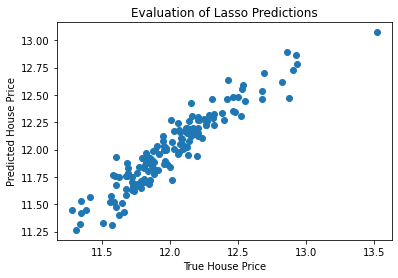

In [15]:
# evaluate predictions in respect to the real sale price
plt.scatter(y_test, price_pipe.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

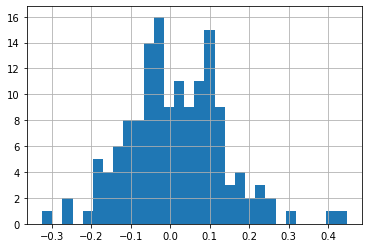

In [16]:
# evaluate the distribution of the errors: 

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(price_pipe.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()